<h1 style="text-align: center;">Marketing Analytics Assignment </h1>

### Prepared by: Vu Duc Cong  

---

## Assignment Objectives

This assignment aims to address key business questions posed by marketing team regarding the effectiveness of discount strategies and other product-related attributes on sales performance.

The analysis is structured around the following core objectives:

---

### 1. Understand the Relationship Between Discount Rate and Conversion Rate
- **Hypothesis:** Higher discount rates lead to higher conversion rates.
- **Goal:** Investigate whether this assumption holds true across:
  - Time (monthly trends)
  - Product categories (e.g., Tables, Beds, Outdoor)
  - Regions (e.g., AU, US, SG)

---

### 2. Explore the Impact of Other Product Features on Conversion Performance
Identify patterns and trends by analyzing the relationship between:
- **Lead Time vs. Conversion Rate:**  
  Does faster shipping translate to better conversion?
- **Category-Level Performance:**  
  Which categories exhibit a **positive correlation** between discounting and conversion?  
  (e.g., detailed time-series analysis for the *Tables* category)
- **SKU-Level Insights:**  
  Which SKUs consistently convert at 5% or higher — and how are they priced and discounted?

---

### End Goal

Enable Castlery to make **smarter, more targeted pricing and promotional decisions** based on product performance and customer behavior, driving higher conversion and more efficient discount usage.



In [30]:
import pandas as pd
import numpy as np

In [31]:
#import purchase data into a data frame
purchase_df = pd.read_excel("Purchase_Data.xlsx")

In [32]:
#import shop data into a data frame
shop_df = pd.read_excel("Shop_Data.xlsx")

In [33]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307452 entries, 0 to 307451
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   market               307452 non-null  object        
 1   region               307452 non-null  object        
 2   date                 307452 non-null  datetime64[ns]
 3   skuid                307452 non-null  object        
 4   curleadtime          307452 non-null  int64         
 5   original_price       307452 non-null  float64       
 6   actual_sale_price    307452 non-null  float64       
 7   daily_quantity_sold  307452 non-null  int64         
 8   product_views        307452 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 21.1+ MB


In [34]:
purchase_df.head(10)

,market,region,date,skuid,curleadtime,original_price,actual_sale_price,daily_quantity_sold,product_views
0,AU,AU Melbourne,2022-08-01,PB-BR0145,48,2497.0,2369.0,2,22
1,AU,AU Melbourne,2022-08-01,52460072-LP4001,53,1299.0,1299.0,5,554
2,AU,AU Melbourne,2022-08-01,40550196,7,269.0,269.0,3,54
3,AU,AU Melbourne,2022-08-01,40550099,77,1049.0,1049.0,1,148
4,AU,AU Melbourne,2022-08-01,PB-LR0171,74,4698.0,4459.0,1,53
5,AU,AU Melbourne,2022-08-01,52460079,7,1399.0,1399.0,2,372
6,AU,AU Melbourne,2022-08-01,52460073-LP4001,7,1399.0,1399.0,1,43
7,AU,AU Melbourne,2022-08-01,50440772-AM4001,33,899.0,899.0,1,185
8,AU,AU Melbourne,2022-08-01,52460074,46,849.0,849.0,2,193
9,AU,AU Melbourne,2022-08-01,T50440978-GI4002,47,1899.0,1899.0,1,27


## Data Cleaning

Before beginning the analysis, several data cleaning steps were taken to ensure accuracy, consistency, and relevance of insights. The following steps were applied to the `purchase_df` and `shop_df` before merging:

---

### 1. Remove Invalid Lead Time Records (`curleadtime`)
- **Issue:** Some rows had a `curleadtime` value of `999`, which indicates a placeholder or data error.
- **Reason:** In a real-world context, a customer waiting 999 days (~3 years) for a product delivery is unrealistic.
- **Action:** All rows with `curleadtime == 999` were removed.
- **Impact:** Only ~5000+ rows were affected out of 300,000+, so overall insights remain unbiased.

---

### 2. Remove Records with `original_price = 0`
- **Issue:** Some rows had `original_price` equal to 0.
- **Reason:** Discount rate is calculated as:  
  Discount = 1 - (Sale Price / Original Price). 
  If `original_price` is 0, this leads to a division error or invalid calculation.
- **Action:** Dropped all rows with `original_price == 0`.

---

### 3. Remove Rows with `product_views = 0`
- **Issue:** Some products had zero product views.
- **Reason:** Conversion rate is defined as:
  Conversion Rate = Daily Quanity Sold / Product Views.
  If `product_views` is 0, conversion cannot be calculated.
- **Action:** Excluded all rows with `product_views == 0`.

---

### 4. Merge `purchase_df` with `shop_df` using `skuid`
- **Issue:** `shop_df` contains duplicate `skuid` entries.
- **Reason:** This caused a one-to-many merge, inflating the number of rows.
- **Action:** Kept only the **first occurrence** of each `skuid` in `shop_df` before merging.
- **Result:** A clean, deduplicated `final_df` used for all analysis.

---

### Final Output: `final_df`
- Cleaned, deduplicated dataset
- Ready for exploratory data analysis and deeper insight generation


In [35]:
# Filter DataFrame for date "2022-08-01"
purchase_df[(purchase_df["date"] == "2022-08-01") & (purchase_df['daily_quantity_sold'] == 0)]
#This shows that only when the product is sold that day, it will be recorded in the record

,market,region,date,skuid,curleadtime,original_price,actual_sale_price,daily_quantity_sold,product_views


In [36]:
purchase_df[purchase_df['skuid'] == 50850025]['region'].nunique()  
#This is to check whether skuid appears in many regions

7

In [37]:
purchase_df[purchase_df['curleadtime'] == 999]['skuid'].count()

5397

In [38]:
filtered_purchase_df = purchase_df[(purchase_df['original_price'] != 0) & 
                          (purchase_df['actual_sale_price'] != 0) &
                          (purchase_df['curleadtime'] != 999) &
                          (purchase_df['product_views'] != 0 )] 

filtered_purchase_df.info()
#The clean data for purchase dataframe contains 252990 rows which will be used for further analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240079 entries, 0 to 307451
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   market               240079 non-null  object        
 1   region               240079 non-null  object        
 2   date                 240079 non-null  datetime64[ns]
 3   skuid                240079 non-null  object        
 4   curleadtime          240079 non-null  int64         
 5   original_price       240079 non-null  float64       
 6   actual_sale_price    240079 non-null  float64       
 7   daily_quantity_sold  240079 non-null  int64         
 8   product_views        240079 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 18.3+ MB


In [39]:
shop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9795 entries, 0 to 9794
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    9795 non-null   object
 1   region    9795 non-null   object
 2   skuid     9795 non-null   object
 3   perfcat   9795 non-null   object
 4   category  9795 non-null   object
dtypes: object(5)
memory usage: 382.7+ KB


In [40]:
shop_df[shop_df['skuid'] == 'T50440981-TL4005'][['market', 'region','category','perfcat']]
# A skuid can have mutiple markets and region, but category and perfcat remains the same

,market,region,category,perfcat
5,AU,AU,Sofa & Armchairs,medium
1797,AU,AU Melbourne,Sofa & Armchairs,medium
2356,AU,AU Sydney,Sofa & Armchairs,medium
4699,US,US East,Sofa & Armchairs,medium
6603,US,US Northwest,Sofa & Armchairs,medium
7457,US,US Southeast,Sofa & Armchairs,medium
9420,US,US West,Sofa & Armchairs,medium


In [41]:
print(filtered_purchase_df['skuid'].nunique())  # Unique SKUs in purchase data
print(shop_df['skuid'].nunique())  # Unique SKUs in shop data

1657
1928


In [42]:
# Since shop_df contains duplicate skuid values, when you perform a merge on skuid,
# each row in filtered_purchase_df gets matched multiple times, causing an increase in the total number of rows in merged_df.

shop_df_unique = shop_df.drop_duplicates(subset=['skuid'])  # Keeps first occurrence
merged_df = pd.merge(filtered_purchase_df, shop_df_unique[['skuid', 'perfcat', 'category']], on='skuid', how='inner')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240079 entries, 0 to 240078
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   market               240079 non-null  object        
 1   region               240079 non-null  object        
 2   date                 240079 non-null  datetime64[ns]
 3   skuid                240079 non-null  object        
 4   curleadtime          240079 non-null  int64         
 5   original_price       240079 non-null  float64       
 6   actual_sale_price    240079 non-null  float64       
 7   daily_quantity_sold  240079 non-null  int64         
 8   product_views        240079 non-null  int64         
 9   perfcat              240079 non-null  object        
 10  category             240079 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 22.0+ MB


In [43]:
#To check the time frame of the dataset
merged_df['date'].max() - merged_df['date'].min()

Timedelta('271 days 00:00:00')

In [44]:
#Create discount_column for each record and conversion_rate
merged_df['discount_percentage'] = round((1 - (merged_df['actual_sale_price'] /merged_df['original_price'])) * 100,3)
merged_df['conversion_rate'] = round(merged_df['daily_quantity_sold'] / merged_df['product_views'] *100 ,3)
merged_df.head(10)

,market,region,date,skuid,curleadtime,original_price,actual_sale_price,daily_quantity_sold,product_views,perfcat,category,discount_percentage,conversion_rate
0,AU,AU Melbourne,2022-08-01,PB-BR0145,48,2497.0,2369.0,2,22,bestseller,Furniture Sets,5.126,9.091
1,AU,AU Melbourne,2022-08-02,PB-BR0145,53,2497.0,2369.0,1,10,bestseller,Furniture Sets,5.126,10.000
2,AU,AU Melbourne,2022-08-03,PB-BR0145,53,2497.0,2369.0,1,8,bestseller,Furniture Sets,5.126,12.500
3,AU,AU Melbourne,2022-08-21,PB-BR0145,54,2497.0,2369.0,1,6,bestseller,Furniture Sets,5.126,16.667
4,AU,AU Melbourne,2022-08-30,PB-BR0145,49,2497.0,2369.0,1,12,bestseller,Furniture Sets,5.126,8.333
5,AU,AU Melbourne,2022-09-11,PB-BR0145,39,2497.0,2369.0,1,4,bestseller,Furniture Sets,5.126,25.000
6,AU,AU Melbourne,2022-09-12,PB-BR0145,37,2497.0,2369.0,1,16,bestseller,Furniture Sets,5.126,6.250
7,AU,AU Melbourne,2022-09-17,PB-BR0145,45,2497.0,2369.0,1,7,bestseller,Furniture Sets,5.126,14.286
8,AU,AU Melbourne,2022-09-23,PB-BR0145,39,2497.0,2369.0,1,8,bestseller,Furniture Sets,5.126,12.500
9,AU,AU Melbourne,2022-09-29,PB-BR0145,34,2497.0,2369.0,1,7,bestseller,Furniture Sets,5.126,14.286


In [50]:
#rename to final_df
final_df = merged_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240079 entries, 0 to 240078
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   market               240079 non-null  object        
 1   region               240079 non-null  object        
 2   date                 240079 non-null  datetime64[ns]
 3   skuid                240079 non-null  object        
 4   curleadtime          240079 non-null  int64         
 5   original_price       240079 non-null  float64       
 6   actual_sale_price    240079 non-null  float64       
 7   daily_quantity_sold  240079 non-null  int64         
 8   product_views        240079 non-null  int64         
 9   perfcat              240079 non-null  object        
 10  category             240079 non-null  object        
 11  discount_percentage  240079 non-null  float64       
 12  conversion_rate      240079 non-null  float64       
dtypes: datetime64[

## Objective 1: Understand the Relationship Between Discount Rate and Conversion Rate

---

###  Hypothesis
> **Higher discount rates will lead to higher conversion rates.**

This assumption is based on general e-commerce behavior: customers are more likely to convert when they are offered a better deal.

---

### Approach

To test this hypothesis, the following steps were taken:

#### 1. **Monthly Aggregation**
- Grouped the data by month.
- Calculated:
  - Average `discount_percentage`
  - Average `conversion_rate`
- Plotted a **dual line chart** to visualize the trends over time.

#### 2. **Market + Category Level Correlation**
- Grouped data by both `market` and `category`.
- Calculated:
  - Average `discount_percentage`
  - Average `conversion_rate`
- Computed **Pearson correlation** between discount and conversion for each group.

#### 3. **Category-Level and Region-Level Deep Dive**
- Created **butterfly charts** to visualize correlation between average discount and conversion:
  - Per category across all markets
  - Per region across all categories

---

### 1. **Monthly Aggregation**
- Grouped the data by month.
- Calculated:
  - Average `discount_percentage`
  - Average `conversion_rate`
- Plotted a **dual line chart** to visualize the trends over time.

In [51]:
# Step 1: Create a new DataFrame with a month column
monthly_df = final_df.copy()
monthly_df['month'] = monthly_df['date'].dt.to_period('M').astype(str)

# Step 2: Group by month and calculate averages
monthly_summary = monthly_df.groupby('month').agg({
    'discount_percentage': 'mean',
    'conversion_rate': 'mean'
}).reset_index()

# Step 3: Rename columns for clarity and round
monthly_summary.rename(columns={
    'discount_percentage': 'avg_discount_rate',
    'conversion_rate': 'avg_conversion_rate'
}, inplace=True)

monthly_summary = monthly_summary.round(3)

# Display the result
print(monthly_summary)

     month  avg_discount_rate  avg_conversion_rate
0  2022-08              4.327                6.250
1  2022-09              5.226                6.806
2  2022-10              4.587                8.323
3  2022-11             11.024                7.130
4  2022-12              5.135                7.442
5  2023-01              4.190                5.930
6  2023-02              4.813                6.413
7  2023-03              4.783                6.787
8  2023-04              3.949                7.626


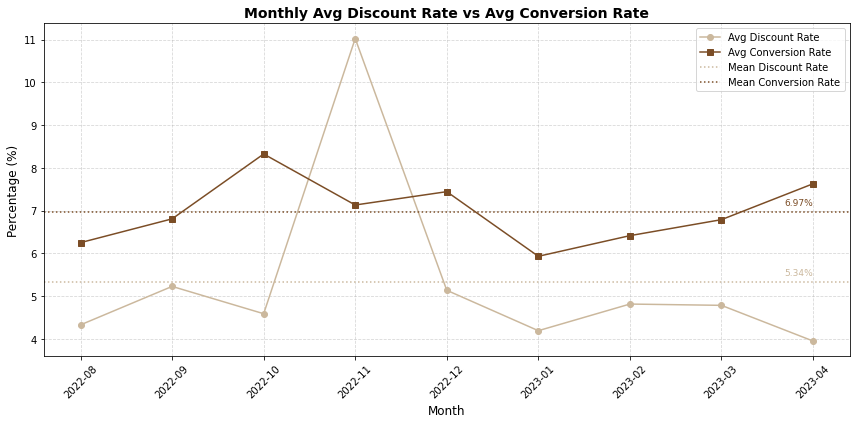

In [52]:
import matplotlib.pyplot as plt

# Custom brown-themed color palette from your template
colors = {
    'discount': '#CBB89D',   # Light Beige
    'conversion': '#7B4D26', # Deep Brown
    'discount_mean': '#CBB89D',
    'conversion_mean': '#7B4D26'
}

# Prepare X-axis labels
months = monthly_summary['month']
x = range(len(months))

# Calculate averages
avg_discount_line = monthly_summary['avg_discount_rate'].mean()
avg_conversion_line = monthly_summary['avg_conversion_rate'].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot line charts
plt.plot(x, monthly_summary['avg_discount_rate'], color=colors['discount'], marker='o', label='Avg Discount Rate')
plt.plot(x, monthly_summary['avg_conversion_rate'], color=colors['conversion'], marker='s', label='Avg Conversion Rate')

# Plot horizontal average lines (dotted)
plt.axhline(avg_discount_line, color=colors['discount_mean'], linestyle=':', linewidth=1.5, label='Mean Discount Rate')
plt.axhline(avg_conversion_line, color=colors['conversion_mean'], linestyle=':', linewidth=1.5, label='Mean Conversion Rate')

# Add average value labels just above the lines
plt.text(x[-1], avg_discount_line + 0.1, f'{avg_discount_line:.2f}%', 
         color=colors['discount'], ha='right', va='bottom', fontsize=9)

plt.text(x[-1], avg_conversion_line + 0.1, f'{avg_conversion_line:.2f}%', 
         color=colors['conversion'], ha='right', va='bottom', fontsize=9)

# X-axis ticks
plt.xticks(ticks=x, labels=months, rotation=45)

# Labels & layout
plt.xlabel('Month', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Monthly Avg Discount Rate vs Avg Conversion Rate', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()

### 2. **Market + Category Level Correlation**

To further understand the relationship between `avg_discount_rate` and `avg_conversion_rate`, we analyzed the data by grouping at the **market** and **category** level. This allows us to spot patterns across different product types and regions.

---

### Methodology

- Grouped the data by **`market`** and **`category`**
- Calculated the following for each group:
  - 🔹 Average `discount_percentage`
  - 🔹 Average `conversion_rate`
  - 🔹 SKU count
- Computed the **Pearson correlation coefficient** to measure the strength and direction of the relationship between discounting and conversions.


In [53]:
# Group by 'market' and 'category' and calculate the required aggregations
grouped_df = final_df.groupby(['region', 'category']).agg({
    'skuid': 'count',  # Count of SKUs in each group
    'discount_percentage': 'mean',  # Average discount rate
    'conversion_rate': 'mean'  # Average conversion rate
}).reset_index()

# Rename columns for clarity
grouped_df.rename(columns={'skuid': 'unique_sku_count', 
                           'discount_percentage': 'avg_discount_rate', 
                           'conversion_rate': 'avg_conversion_rate'}, inplace=True)

# Round numerical values to 3 decimal places
grouped_df = grouped_df.round(3)

grouped_df.head(12)

,region,category,unique_sku_count,avg_discount_rate,avg_conversion_rate
0,AU Melbourne,Accessories,1150,3.565,26.519
1,AU Melbourne,Beds,1405,2.550,4.747
2,AU Melbourne,Chairs & Benches,1768,4.077,5.266
3,AU Melbourne,Furniture Sets,1588,8.552,14.823
4,AU Melbourne,Lightings,148,3.816,5.157
5,AU Melbourne,Outdoor,1457,13.779,17.648
6,AU Melbourne,Sofa & Armchairs,4099,4.128,9.073
7,AU Melbourne,Storage,1544,3.061,1.713
8,AU Melbourne,Tables,2377,2.907,3.010
9,AU Melbourne,Tableware,53,0.000,15.706


**To understand the overall correlation between avg_discount_rate and avg_conversion_rate, I will use:**
1. Correlation Analysis 
2. Scatter Plot Visualisation

In [54]:
import scipy.stats as stats

# Compute correlation between discount rate and conversion rate
correlation, p_value = stats.pearsonr(grouped_df['avg_discount_rate'], grouped_df['avg_conversion_rate'])

print(f"Pearson Correlation: {correlation:.3f}")

Pearson Correlation: 0.171


**Key Findings**

- **No strong overall correlation** between discount rate and conversion rate.
  - Monthly trends showed both metrics **fluctuate independently**.
  - Pearson correlation across all market/category combinations ≈ **0.17**

**Interpretation** 

Correlation close to **+1** → Strong positive relationship (Higher discounts lead to higher conversion).

Correlation close to **-1** → Strong negative relationship (Higher discounts reduce conversions).

Correlation close to **0** → No clear relationship.

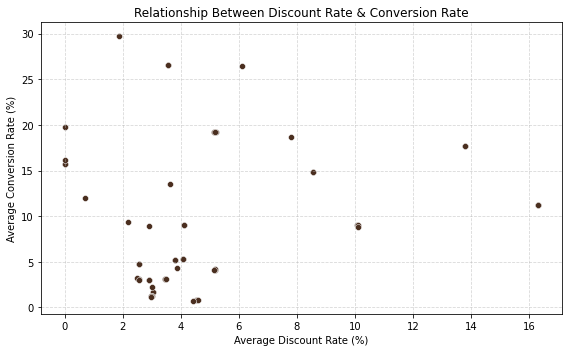

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=grouped_df['avg_discount_rate'],
    y=grouped_df['avg_conversion_rate'],
    color='#4A2E1F'  # Brown color
)
plt.xlabel("Average Discount Rate (%)")
plt.ylabel("Average Conversion Rate (%)")
plt.title("Relationship Between Discount Rate & Conversion Rate")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 3 Category-Level Correlation: Discount vs. Conversion
#### 3.1 Category-Level Correlation: Discount vs. Conversion

After observing no strong overall correlation between discount rate and conversion rate, we conducted a deeper analysis by examining **category-specific behavior**.

---

#### Part 1: Visualizing Category Trends by Region

To explore how different product categories respond to discounting, we:
- Created **scatter plots** for each product category
- Color-coded each point by **region** (e.g., AU, US, SG)
- Plotted a **regression line** to reveal the general trend for each category

This approach reveals both:
- **Intra-category relationships** (discount vs. conversion for products of the same type)
- **Cross-regional differences** (how categories behave in different markets)

---

#### Part 2: Correlation Coefficient by Category

We then computed the **Pearson correlation coefficient** between `avg_discount_rate` and `avg_conversion_rate` at the **category level**, and visualized it in a **butterfly-style bar chart**:

- **Positive correlation** → Discounts tend to improve conversion rates
- **Negative correlation** → Discounts may not be effective or could hurt performance
- **Near-zero correlation** → No meaningful relationship

---

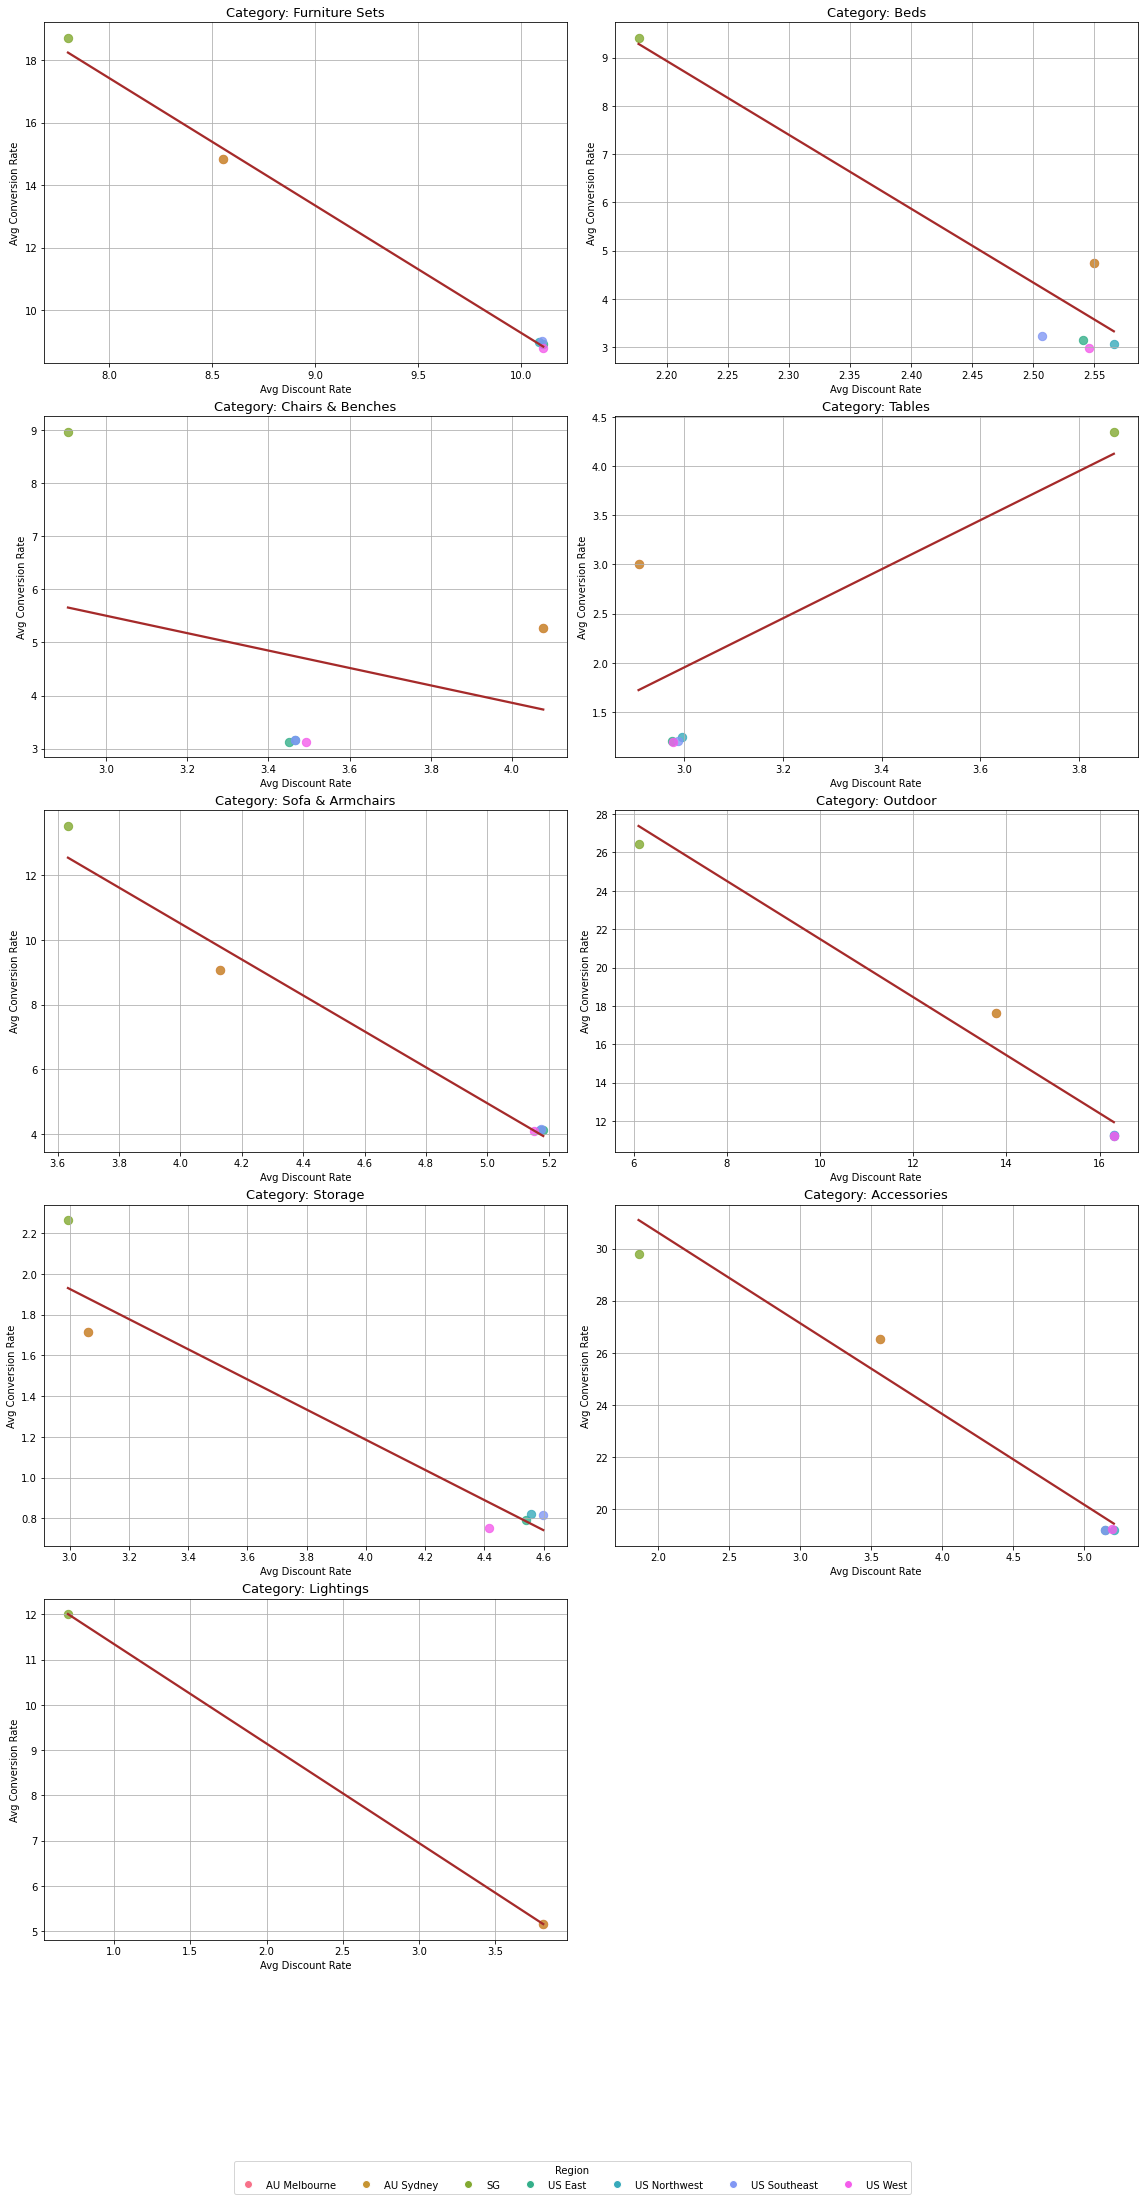

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_category_correlation_scatter(grouped_df):
    """
    For each product category, plot a scatter plot of avg_discount_rate vs avg_conversion_rate,
    color-coded by region, with a single regression line per category and a shared legend.
    """
    # we exclude Matresses and Tablewares because they do not have any discounts
    categories = ['Furniture Sets', 'Beds', 'Chairs & Benches', 'Tables',
                  'Sofa & Armchairs', 'Outdoor', 'Storage', 'Accessories', 'Lightings']

    regions = grouped_df['region'].unique()
    palette = sns.color_palette("husl", len(regions))
    region_color_map = dict(zip(regions, palette))

    # Setup subplot grid
    n_cols = 2
    n_rows = (len(categories) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    for i, cat in enumerate(categories):
        subset = grouped_df[grouped_df['category'] == cat]

        if len(subset) < 2:
            continue

        ax = axes[i]

        # Scatter points with region color
        for region in regions:
            region_data = subset[subset['region'] == region]
            ax.scatter(
                region_data['avg_discount_rate'],
                region_data['avg_conversion_rate'],
                label=region,
                color=region_color_map[region],
                s=70,
                alpha=0.8
            )

        # Plot a single regression line (across all regions)
        sns.regplot(
            data=subset,
            x='avg_discount_rate',
            y='avg_conversion_rate',
            scatter=False,
            line_kws={'color': 'brown'},
            ci=None,
            ax=ax
        )

        ax.set_title(f'Category: {cat}', fontsize=13)
        ax.set_xlabel('Avg Discount Rate')
        ax.set_ylabel('Avg Conversion Rate')
        ax.grid(True)

    # Remove extra axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Shared legend for regions
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=region,
                          markerfacecolor=color, markersize=8)
               for region, color in region_color_map.items()]

    fig.legend(handles=handles, title='Region', loc='lower center', ncol=len(regions), bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

plot_category_correlation_scatter(grouped_df)

**Insights:**
- `Tables` shows a strong **upward-sloping regression line**, indicating that discounts are effective in increasing conversions across most regions.
- Several other categories (e.g., `Furniture Sets`, `Storage`, `Beds`) show **flat or downward slopes**, suggesting minimal or negative effects from discounting.
- Indicates that discount strategies should be **tailored by product category**, not applied universally.


In [57]:
correlation_by_category = grouped_df.groupby('category')[['avg_discount_rate', 'avg_conversion_rate']].corr().unstack().iloc[:, 1].sort_values(ascending = False)
correlation_by_category

category
Tables              0.676596
Chairs & Benches   -0.307112
Beds               -0.925796
Storage            -0.957376
Outdoor            -0.974929
Accessories        -0.976617
Sofa & Armchairs   -0.987586
Furniture Sets     -0.997492
Lightings          -1.000000
Mattresses               NaN
Tableware                NaN
Name: (avg_discount_rate, avg_conversion_rate), dtype: float64

**Component	of What It Does**

.corr(): Calculates correlation matrix

.unstack(): Reshapes MultiIndex to columns

.iloc[:, 1]: Extracts correlation between discount & conversion

.sort_values(): Ranks categories by strength of relationship

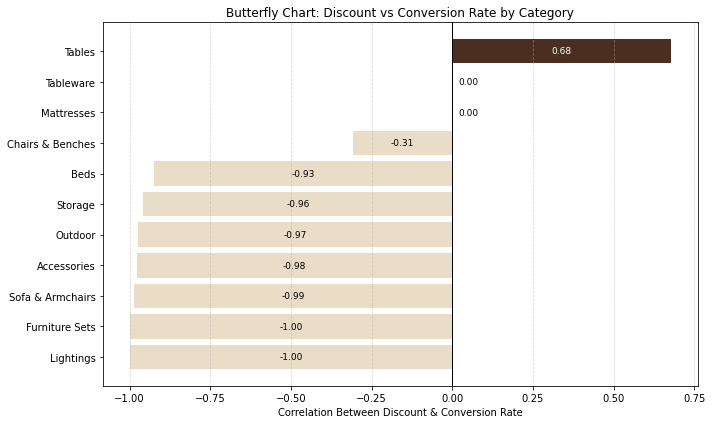

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the series to a DataFrame
correlation_by_category_df = correlation_by_category.reset_index()
correlation_by_category_df.columns = ['category', 'correlation']

# Handle NaN and infinite values
correlation_by_category_df['correlation'].replace([np.inf, -np.inf], np.nan, inplace=True)
correlation_by_category_df['correlation'].fillna(0, inplace=True)

# Sort by correlation value
correlation_by_category_df.sort_values('correlation', inplace=True)

# Define custom colors
beige = '#EADDC7'
brown = '#4A2E1F'

# Assign color based on correlation sign
colors = [brown if val > 0 else beige for val in correlation_by_category_df['correlation']]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(
    correlation_by_category_df['category'],
    correlation_by_category_df['correlation'],
    color=colors
)

# Add value labels
for bar, val in zip(bars, correlation_by_category_df['correlation']):
    width = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2

    if width == 0:
        plt.text(0.02, y_center, '0.00', va='center', ha='left', fontsize=9)
    else:
        text_color = 'white' if val > 0 else 'black'
        plt.text(width / 2, y_center, f'{val:.2f}', va='center', ha='center', fontsize=9, color=text_color)

# Styling
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Correlation Between Discount & Conversion Rate')
plt.title('Butterfly Chart: Discount vs Conversion Rate by Category')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Key Finding:**
- `Tables` is the **only category with a strong positive correlation** (`+0.68`)
- All other major categories (e.g., `Beds`, `Outdoor`, `Accessories`, `Sofa & Armchairs`) show **strong negative correlations**, some near `-1.0`
- Suggests `Tables` is a strong candidate for **discount-driven campaigns**, while other categories may require **non-pricing-based strategies**

#### 3.2 Region-Level Correlation: Discount vs. Conversion Rate

After examining the relationship between discount rates and conversion rates across categories, we now shift our focus to understanding how this relationship varies across **different regions**.

The goal is to explore whether customer behavior in response to discounts is influenced by the **market region** where the product is sold.

---

#### Step 1: Visual Exploration — Region-wise Scatter & Regression Plots

To begin, we plot **scatter plots for each region**, where:
- Each point represents a unique **product category** within that region.
- X-axis: Average Discount Rate
- Y-axis: Average Conversion Rate
- Points are **color-coded by category**
- A **regression line** is added to capture the overall trend

This visualization allows us to:
- Observe how tightly the conversion rate tracks with discount rate per region
- Detect regional differences in pricing responsiveness
- Understand which categories are more discount-sensitive in each region

> Interpretation becomes easier by visually comparing gradient directions and data spread across regions.

---

#### Step 2: Quantitative Measure — Pearson Correlation by Region

Next, we compute the **Pearson correlation coefficient** between `avg_discount_rate` and `avg_conversion_rate` for each region.

This gives us a statistical metric indicating the **strength and direction of the relationship**:

- **+1** → Strong positive correlation (higher discounts lead to more conversions)
- **0** → No correlation
- **-1** → Strong negative correlation

We visualize this using a **butterfly bar chart**, where:
- Each bar represents a region
- The correlation value is displayed on each bar for easy reference

---


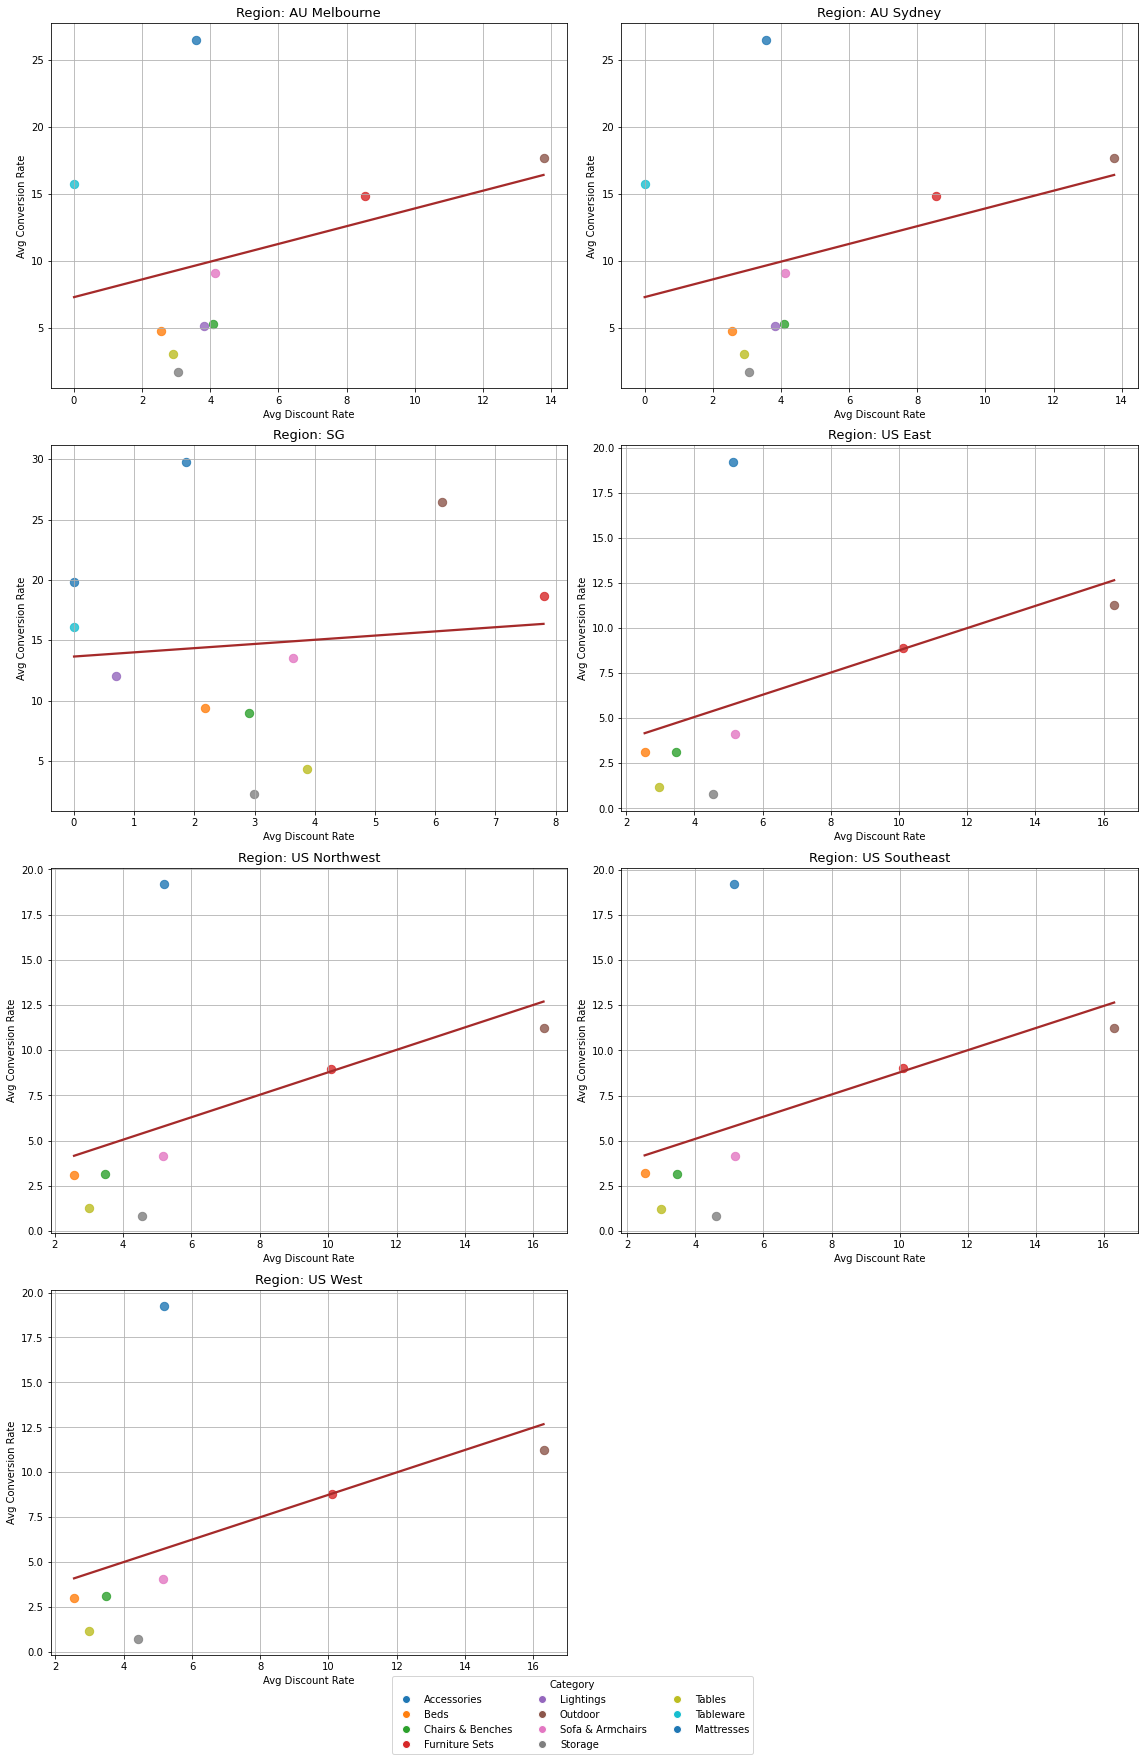

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_region_correlation_scatter(grouped_df):
    """
    For each region, plot avg_discount_rate vs avg_conversion_rate
    across all categories, with a best-fit regression line.
    Points are colored by category, legend is shared.
    """
    regions = grouped_df['region'].unique()
    categories = grouped_df['category'].unique()
    palette = sns.color_palette("tab10", len(categories))
    category_color_map = dict(zip(categories, palette))

    n_cols = 2
    n_rows = (len(regions) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    for i, region in enumerate(regions):
        subset = grouped_df[grouped_df['region'] == region]

        if len(subset) < 2:
            continue

        ax = axes[i]

        # Scatter points colored by category
        for category in categories:
            cat_data = subset[subset['category'] == category]
            if not cat_data.empty:
                ax.scatter(
                    cat_data['avg_discount_rate'],
                    cat_data['avg_conversion_rate'],
                    label=category,
                    color=category_color_map[category],
                    s=70,
                    alpha=0.8
                )

        # Regression line (across all categories in this region)
        sns.regplot(
            data=subset,
            x='avg_discount_rate',
            y='avg_conversion_rate',
            scatter=False,
            line_kws={'color': 'brown'},
            ci=None,
            ax=ax
        )

        ax.set_title(f'Region: {region}', fontsize=13)
        ax.set_xlabel('Avg Discount Rate')
        ax.set_ylabel('Avg Conversion Rate')
        ax.grid(True)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Shared legend for categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                          markerfacecolor=color, markersize=8)
               for category, color in category_color_map.items()]

    fig.legend(handles=handles, title='Category', loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.04)
    plt.show()

# Run the function
plot_region_correlation_scatter(grouped_df)

In [60]:
correlation_by_region = grouped_df.groupby('region')[['avg_discount_rate', 'avg_conversion_rate']].corr().unstack().iloc[:, 1].sort_values(ascending = False)
correlation_by_region

region
US West         0.461546
US Northwest    0.460538
US East         0.457192
US Southeast    0.455594
AU Melbourne    0.317276
AU Sydney       0.317276
SG              0.097925
Name: (avg_discount_rate, avg_conversion_rate), dtype: float64

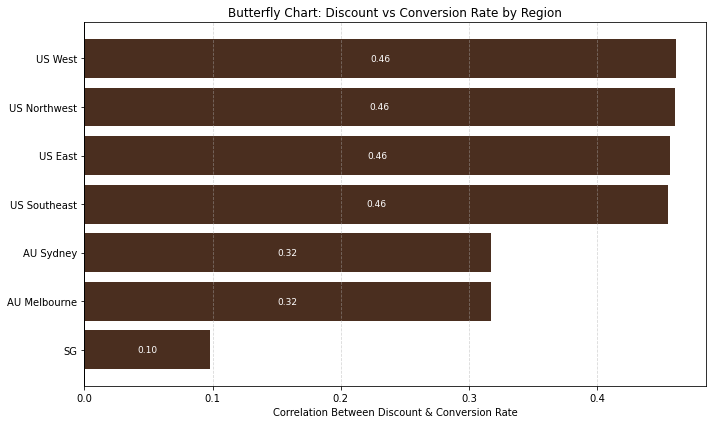

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the Series to a DataFrame
correlation_by_region_df = correlation_by_region.reset_index()
correlation_by_region_df.columns = ['region', 'correlation']

# Replace NaN or inf with 0
correlation_by_region_df['correlation'].replace([np.inf, -np.inf], np.nan, inplace=True)
correlation_by_region_df['correlation'].fillna(0, inplace=True)

# Sort values for better visual order
correlation_by_region_df.sort_values('correlation', inplace=True)

# Color scheme
beige = '#EADDC7'
brown = '#4A2E1F'
colors = [brown if val > 0 else beige for val in correlation_by_region_df['correlation']]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    correlation_by_region_df['region'],
    correlation_by_region_df['correlation'],
    color=colors
)

# Add labels
for bar, val in zip(bars, correlation_by_region_df['correlation']):
    width = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2

    if width == 0:
        plt.text(0.02, y_center, '0.00', va='center', ha='left', fontsize=9)
    else:
        text_color = 'white' if val > 0 else 'black'
        plt.text(width / 2, y_center, f'{val:.2f}', va='center', ha='center', fontsize=9, color=text_color)

# Styling
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Correlation Between Discount & Conversion Rate')
plt.title('Butterfly Chart: Discount vs Conversion Rate by Region')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

####  Key Finding

- **US & AU Regions** show **moderate positive correlation** (r ≈ 0.31 to 0.46):
  - This implies that in these markets, discounts do tend to **improve conversion rates**.
  - Marketing efforts involving discount campaigns may be more effective here.

- **SG (Singapore)** exhibits a **weak correlation** (r ≈ 0.1):
  - Consumers in this region may not be as price-sensitive.
  - Conversion strategies could focus on **non-price factors** like shipping, exclusivity, or bundling.

- Region-specific trends suggest the need for **localised pricing strategies** rather than a one-size-fits-all approach.

---


### Analysis for Objective 1:

---

#### 1. Initial Hypothesis

> *“I initially hypothesized that increasing the product discount rate would lead to higher conversion rates — that is, customers are more likely to purchase when discounts are deeper.”*

This assumption reflects common marketing logic and consumer behavior in e-commerce: discounts drive urgency and lower price resistance. However, the data tells a more nuanced story.

---

#### 2. Investigation Across Multiple Dimensions

##### **By Month (Time Trend)**

- Analyzed avg discount and conversion rate from **Aug 2022 to Apr 2023**.
- Notable **spike in discount** during **Nov 2022** (Black Friday, 11.11 sales), yet conversion rate was **not the highest**.
- **October 2022**, with only **moderate discounting**, had the **highest average conversion rate**.

**Insight:**  
→ **Timing**, **campaign planning**, and **seasonality** may play a bigger role than discount depth in driving conversions. 

→ The time series graph shows that there is **no clear relationship** between discount rate and conversion.

---

##### **By Product Category**

- Only the **Tables** category showed a **strong positive correlation** between discount rate and conversion rate.
- Categories like **Furniture Sets**, **Sofas**, **Accessories**, and **Beds** had a **negative correlation**, where higher discounts led to **lower conversion**.

**Insight:**  
→ Customers in premium categories may associate discounting with **lower perceived value**, which reduces urgency and weakens brand equity.

---

##### **By Region**

- **US regions** showed **moderate positive correlation** (~0.31 to 0.46) — discounts help conversions.
- **Australia** showed a weaker positive trend.
- **Singapore** showed **almost no correlation**, suggesting discounts are **less effective** in driving purchases.

**Insight:**  
→ **Consumer behavior and price sensitivity vary by region**, so localised strategies are necessary.

---

#### 3. Was the Hypothesis Supported?

> **No.**  
The data does **not** support the hypothesis that higher discounts universally lead to higher conversion rates.

In fact, in several cases — especially in premium product categories — deeper discounts were associated with **lower conversion rates**.

This shows the importance of **testing assumptions**, and highlights your ability to challenge standard thinking with data-driven evidence.

---

#### 4. Strategic Recommendations

---

#####  4A. Use Targeted Discounts 

- Apply discounting strategies to **categories where they work**, like **Tables**.
- Avoid over-discounting in premium segments where it may reduce perceived value.
- Use value-driven messaging instead (e.g., lifestyle, quality, limited editions).

---

##### 4B. Localize Discount Strategies by Market

- **Be aggressive in U.S and Autralia markets**, where customers respond positively to discounts.
- In **Singapore**, focus on **non-price factors** like convenience, exclusivity, and trust.

---

#####  4C. Prioritize Campaign Timing Over Discount Depth

- **October 2022** had the highest conversion rate despite average discounts.
- Plan around **key seasons**, **collection drops**, and **buying cycles**.
- Combine **moderate discounts** with **strategic campaign timing** to maximize impact.

---

##### 4D. Test, Measure, and Personalize

- Run **A/B tests** on discount levels across categories or customer segments.
- Test **personalized discounts** (“Your saved item is now 5% off”) to enhance engagement.
- Measure conversion lift not just by rate, but by **incremental volume** and **margin impact**.

---


## Objective 2: Explore the Impact of Other Product Features on Conversion Performance

This objective investigates how **non-discount features** affect a product’s ability to convert — focusing on:

- **Lead Time** — Does faster delivery drive more sales?
- **Category Trends** — Which categories show a clear response to discounts?
- **SKU-Level Insights** — Which products consistently perform well and what discount strategies can be applied?


###  2.1 Lead Time vs. Conversion Rate

#### Hypothesis:
> “Shorter lead times will lead to higher conversion rates, as customers prefer fast shipping.”


In [62]:
final_df.head(10)

,market,region,date,skuid,curleadtime,original_price,actual_sale_price,daily_quantity_sold,product_views,perfcat,category,discount_percentage,conversion_rate
0,AU,AU Melbourne,2022-08-01,PB-BR0145,48,2497.0,2369.0,2,22,bestseller,Furniture Sets,5.126,9.091
1,AU,AU Melbourne,2022-08-02,PB-BR0145,53,2497.0,2369.0,1,10,bestseller,Furniture Sets,5.126,10.000
2,AU,AU Melbourne,2022-08-03,PB-BR0145,53,2497.0,2369.0,1,8,bestseller,Furniture Sets,5.126,12.500
3,AU,AU Melbourne,2022-08-21,PB-BR0145,54,2497.0,2369.0,1,6,bestseller,Furniture Sets,5.126,16.667
4,AU,AU Melbourne,2022-08-30,PB-BR0145,49,2497.0,2369.0,1,12,bestseller,Furniture Sets,5.126,8.333
5,AU,AU Melbourne,2022-09-11,PB-BR0145,39,2497.0,2369.0,1,4,bestseller,Furniture Sets,5.126,25.000
6,AU,AU Melbourne,2022-09-12,PB-BR0145,37,2497.0,2369.0,1,16,bestseller,Furniture Sets,5.126,6.250
7,AU,AU Melbourne,2022-09-17,PB-BR0145,45,2497.0,2369.0,1,7,bestseller,Furniture Sets,5.126,14.286
8,AU,AU Melbourne,2022-09-23,PB-BR0145,39,2497.0,2369.0,1,8,bestseller,Furniture Sets,5.126,12.500
9,AU,AU Melbourne,2022-09-29,PB-BR0145,34,2497.0,2369.0,1,7,bestseller,Furniture Sets,5.126,14.286


In [63]:
#There are many unique curleadtime
final_df['curleadtime'].unique()

array([ 48,  53,  54,  49,  39,  37,  45,  34,  22,   7,   5,  26,  28,
        27,  23,  24,  18,   6,  12,  11,  59,  66,  64,  63,  61,  58,
        57,  56,  52,  65,  38,  35,  36,  32,  29,  30,  31,  21,  20,
        78,  76,  70,  50,  43,  73,  71,  25,  55,  41,  15,  19,  17,
        40,  42,  10,  62,  47,  60,  51,  46,   9,  77,  44,  16,  13,
        14,  33,  74,  80, 110,  69, 102,  67,  68, 128, 126, 124,  92,
        90,  88,  87,  75,  97,  95,  96, 122,  99, 100,  89,  83, 115,
       113, 101,  94,  81,  79,  72,   8,  82,  93, 105,  91,  86,  98,
       107, 108,  84, 140, 138, 125, 169, 167, 103, 141, 130, 134, 123,
       163, 117, 114, 112, 109, 170, 166, 147, 142, 120, 118, 106, 116,
       179, 148, 173, 197, 196, 186, 184, 177, 159, 172, 157, 155, 152,
       132, 211, 212, 200, 198, 191, 181,  85, 174, 162, 160, 153, 137,
       150, 145, 143, 127, 176, 164, 139, 136, 133, 131, 206, 119, 104,
       149, 168, 158, 151, 121, 205, 270, 269, 261, 129, 178, 11

In [64]:
#Check for the frequency of the each unique curleadtime
leadtime_counts = final_df['curleadtime'].value_counts().sort_index()
print(leadtime_counts)

rare_leadtimes = leadtime_counts[leadtime_counts < 2].count()
print(rare_leadtimes)

5      21078
6      26391
7      96715
8        194
9      19494
       ...  
315        4
317        4
319        1
321        1
323        1
Name: curleadtime, Length: 286, dtype: int64
12


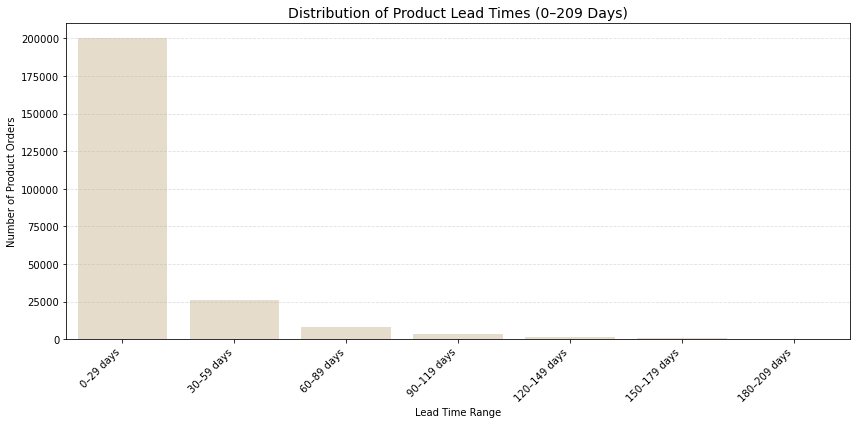

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Filter the data to include only realistic lead times (≤ 180 days)
filtered_df = final_df[final_df['curleadtime'] <= 180].copy()

# Step 2: Define bins and labels
bins = list(range(0, 211, 30))  # [0, 30, 60, ..., 210]
labels = [f'{bins[i]}–{bins[i+1] - 1} days' for i in range(len(bins) - 1)]

# Step 3: Create a new column with binned lead time
filtered_df['leadtime_bin'] = pd.cut(filtered_df['curleadtime'], bins=bins, labels=labels, right=False)

# Step 4: Plot the histogram using seaborn
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='leadtime_bin', color = '#EADDC7')

# Step 5: Styling and formatting
plt.title('Distribution of Product Lead Times (0–209 Days)', fontsize=14)
plt.xlabel('Lead Time Range')
plt.ylabel('Number of Product Orders')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Why Lead Time Was Binned Between 0 and 180 Days

To analyze the relationship between **lead time** (curleadtime) and **conversion rate**, we focused only on values within the range of **0 to 180 days** (approximately 6 months). This decision was based on:

- **Business Context**:  
  In a real-world retail setting, it is uncommon and impractical for customers to wait over 6 months for a product to ship. Longer lead times may represent **pre-orders**, **custom builds**, or **data anomalies**.

- **Data Distribution**:  
  Over **95% of the records** fall within the 0–180 day range, with the majority around **7–30 days**. Values beyond 180 days are **extremely rare and sparsely distributed**, with most appearing fewer than 10 times.

- **Impact on Analysis**:  
  Including these outliers would **skew the distribution**, affect binning accuracy, and potentially lead to **misleading averages** in conversion performance.

By excluding outliers and binning only up to 180 days, we ensure:
- A **more balanced** and **interpretable** analysis
- Focus on lead times that are **operationally relevant** and **actionable** for Castlery


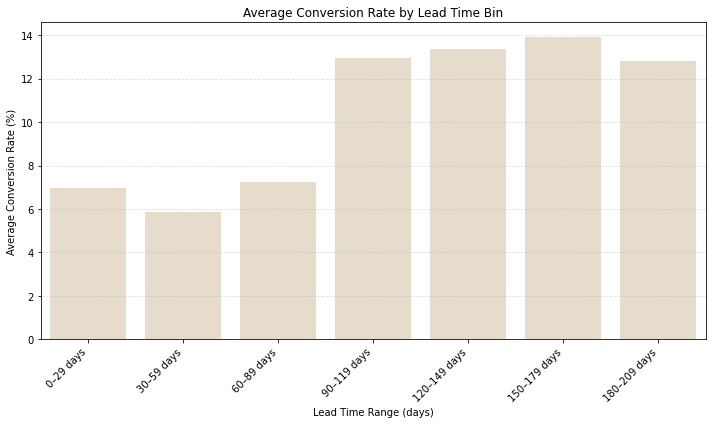

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter to include only realistic lead times (≤ 180 days)
filtered_df = final_df[final_df['curleadtime'] <= 180].copy()

# Step 2: Create lead time bins (e.g., 0–29, 30–59, ..., 180–209)
bins = list(range(0, 211, 30))  # [0, 30, 60, ..., 210]
labels = [f'{bins[i]}–{bins[i+1]-1} days' for i in range(len(bins)-1)]

# Step 3: Assign bins to each row
filtered_df['leadtime_bin'] = pd.cut(filtered_df['curleadtime'], bins=bins, labels=labels, right=False)

# Step 4: Group by bin and calculate average conversion rate
leadtime_conversion_summary = (
    filtered_df.groupby('leadtime_bin')['conversion_rate']
    .mean()
    .reset_index()
    .rename(columns={'conversion_rate': 'avg_conversion_rate'})
)

# Step 5: Plot average conversion rate per lead time bin
plt.figure(figsize=(10, 6))
sns.barplot(
    data=leadtime_conversion_summary,
    x='leadtime_bin',
    y='avg_conversion_rate',
    color = '#EADDC7'
)

# Step 6: Styling
plt.title('Average Conversion Rate by Lead Time Bin')
plt.xlabel('Lead Time Range (days)')
plt.ylabel('Average Conversion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# Show the chart
plt.show()

**Key Finding**
- **Hypothesis not supported** — Shorter lead times (0–30 days) had **lower conversion rates** on average.
- **Products with longer lead times (90–180 days)** showed the **highest average conversion rates**.
- However, these longer lead time bins had far fewer SKUs, suggesting potential bias from **high-intent or pre-order items**.
- **Most products had 7-day lead time** → skewed distribution.

#### 💡 Takeaway:
> Conversion performance appears more driven by **product desirability or uniqueness**, not just speed of delivery.

### 2.2 Category-Level Performance (Zoom-In on "Tables" Category)

Earlier, we discovered that the **Tables** category was the only one to exhibit a **strong positive correlation** between discount rate and conversion rate.

#### What I did:
- Filtered data to just the Tables category.
- Aggregated discount & conversion monthly.
- Visualized trends across time.

In [67]:
tables_df = final_df[final_df['category'] == 'Tables']

In [68]:
tables_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35437 entries, 1546 to 239540
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   market               35437 non-null  object        
 1   region               35437 non-null  object        
 2   date                 35437 non-null  datetime64[ns]
 3   skuid                35437 non-null  object        
 4   curleadtime          35437 non-null  int64         
 5   original_price       35437 non-null  float64       
 6   actual_sale_price    35437 non-null  float64       
 7   daily_quantity_sold  35437 non-null  int64         
 8   product_views        35437 non-null  int64         
 9   perfcat              35437 non-null  object        
 10  category             35437 non-null  object        
 11  discount_percentage  35437 non-null  float64       
 12  conversion_rate      35437 non-null  float64       
dtypes: datetime64[ns](1), float

In [69]:
# Step 1: Filter to only 'Tables' category
tables_df = final_df[final_df['category'] == 'Tables'].copy()

# Step 2: Create 'month' column
tables_df['month'] = tables_df['date'].dt.to_period('M').astype(str)

# Step 3: Group by month and aggregate
tables_monthly_summary = tables_df.groupby('month').agg({
    'discount_percentage': 'mean',
    'conversion_rate': 'mean',
    'daily_quantity_sold': 'sum',
    'product_views': 'sum'
}).reset_index().round(2)

# Optional: Sort by conversion or discount
tables_monthly_summary = tables_monthly_summary.sort_values('month')

# View results
print(tables_monthly_summary)

     month  discount_percentage  conversion_rate  daily_quantity_sold  \
0  2022-08                 2.03             2.14                 8194   
1  2022-09                 1.88             2.18                 8807   
2  2022-10                 2.00             2.10                 8786   
3  2022-11                 5.68             2.19                11453   
4  2022-12                 3.42             1.83                 7080   
5  2023-01                 2.68             1.30                 6739   
6  2023-02                 3.58             1.28                 6633   
7  2023-03                 3.67             1.60                 8123   
8  2023-04                 2.44             1.66                 6819   

   product_views  
0        1564747  
1        1593914  
2        1297077  
3        1651408  
4        1000370  
5        1277262  
6        1333304  
7        1504805  
8         981474  


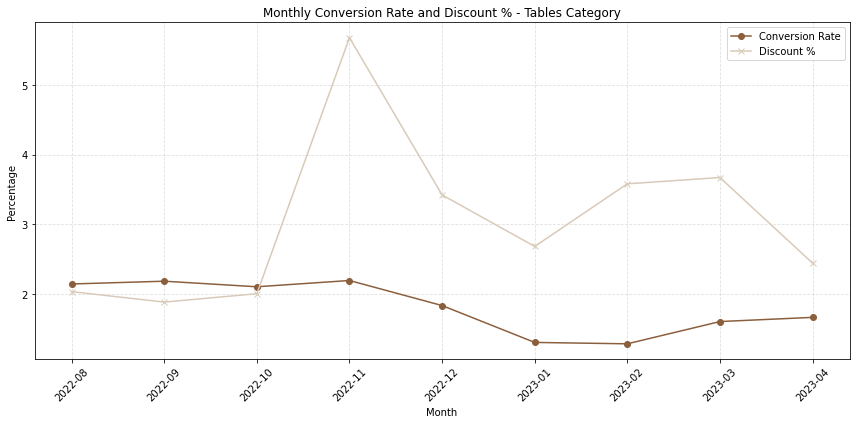

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Updated colors: beige and brown
plt.plot(
    tables_monthly_summary['month'],
    tables_monthly_summary['conversion_rate'],
    label='Conversion Rate',
    marker='o',
    color='#8B5E3C'  # Brown
)

plt.plot(
    tables_monthly_summary['month'],
    tables_monthly_summary['discount_percentage'],
    label='Discount %',
    marker='x',
    color='#D8CAB8'  # Beige
)

plt.title('Monthly Conversion Rate and Discount % - Tables Category')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Key Finding**
- In **Nov 2022**, a higher discount (5.7%) led to a noticeable **increase in conversion** and **sales volume**.
- This supports the idea that Tables are **price-sensitive** — and more responsive to discount-based campaigns.
- In months with low discounting (e.g., Mar–Apr 2023), conversion rates remained modest.

#### 💡 Takeaway:
> **Tables respond well to discounts.** These products are likely highly comparable across competitors and benefit from price-based decision-making.

### 🔍 2.3 SKU-Level Insights: High Conversion Drivers (≥ 5%)

We isolated top-performing SKUs (within Tables) to understand:

- Are they already discounted?
- Can we boost conversions further?

In [71]:
tables_df.head(10)

,market,region,date,skuid,curleadtime,original_price,actual_sale_price,daily_quantity_sold,product_views,perfcat,category,discount_percentage,conversion_rate,month
1546,AU,AU Melbourne,2022-08-01,40550099,77,1049.0,1049.0,1,148,bestseller,Tables,0.0,0.676,2022-08
1547,AU,AU Melbourne,2022-08-04,40550099,63,1049.0,1049.0,1,156,bestseller,Tables,0.0,0.641,2022-08
1548,AU,AU Melbourne,2022-08-06,40550099,61,1049.0,1049.0,1,339,bestseller,Tables,0.0,0.295,2022-08
1549,AU,AU Melbourne,2022-08-07,40550099,59,1049.0,1049.0,4,363,bestseller,Tables,0.0,1.102,2022-08
1550,AU,AU Melbourne,2022-08-08,40550099,57,1049.0,1049.0,1,306,bestseller,Tables,0.0,0.327,2022-08
1551,AU,AU Melbourne,2022-08-09,40550099,58,1049.0,1049.0,3,267,bestseller,Tables,0.0,1.124,2022-08
1552,AU,AU Melbourne,2022-08-11,40550099,57,1049.0,1049.0,1,339,bestseller,Tables,0.0,0.295,2022-08
1553,AU,AU Melbourne,2022-08-16,40550099,50,1049.0,1049.0,1,450,bestseller,Tables,0.0,0.222,2022-08
1554,AU,AU Melbourne,2022-08-17,40550099,49,1049.0,1049.0,2,379,bestseller,Tables,0.0,0.528,2022-08
1555,AU,AU Melbourne,2022-08-18,40550099,48,1049.0,1049.0,1,381,bestseller,Tables,0.0,0.262,2022-08


In [74]:
# Group by SKU and calculate mean discount and conversion rate
sku_performance = tables_df.groupby('skuid').agg({
    'discount_percentage': 'mean',
    'conversion_rate': 'mean'
}).reset_index().round(2)

# Sort by conversion rate (optional)
sku_performance = sku_performance.sort_values(by='conversion_rate', ascending=False)

# View result
print(sku_performance.head(14))

        skuid  discount_percentage  conversion_rate
61   52460093                 3.49            15.65
67  T50441013                13.12            12.63
17   40550187                13.42            11.84
48   52460039                 0.00            11.27
37   50440704                 0.00            11.11
18   40550188                11.86            10.20
47   52460036                 0.00            10.17
70  T50441119                 0.00             8.80
5    40550078                 7.02             8.05
68  T50441014                16.05             7.85
66  T50441012                19.59             7.82
72  T50441122                14.46             7.35
30   41960002                 1.18             5.78
57   52460089                 1.78             5.51


#### Strategy:
- Filtered for SKUs with **conversion rate ≥ 5%**.
- Segmented into 3 action groups based on current discount rate.

#### Recommendations:

| Segment                      | Action                       | SKUid           |
|-----------------------------|------------------------------|------------------------|
| 1. Introduce Discount       | Convert well *without* discount — try 5–10% | `52460039`, `50440704`, `T50441119`, `52460036` |
| 2. Slightly Raise Discount  | Already discounted ~3–5%, test deeper discount | `52460093`, `41960002`, `52460089` |
| 3. Maintain Current Discount| Strong performance at 6–16%, no change needed | The rest |

#### 💡 Takeaway:
> **Not all high-performing products need aggressive discounting.** Use data to optimize spend and avoid unnecessary margin cuts.

### Final Summary for Objective 2

| Feature       | Is it a driver of conversion? | Action                                        |
|---------------|-------------------------------|-----------------------------------------------|
| Lead Time     | ❌ Not directly                | Focus on product value, not speed             |
| Category Type | ✅ (For Tables Category only)              | Target discounts to price-sensitive segments  |
| SKU-Level     | ✅ (For Tables Category)                        | Personalize discount strategy by SKU behavior |

